In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import geopandas as gpd
import descartes
import statsmodels.formula.api as smf
import statsmodels.api as sm

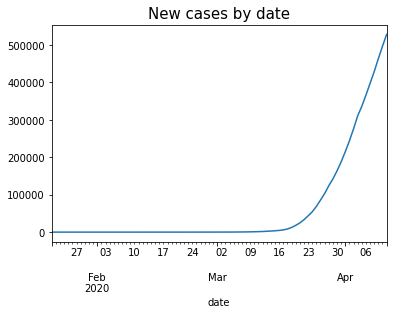

In [2]:
#### Data preparation

## COVID18 panel of daily cases
covid = pd.read_csv('us-counties.csv', dtype={'fips' : 'str'})
covid.date = pd.to_datetime(covid.date)
covid.sort_values(['state', 'county', 'date'], inplace=True)
covid['cum_cases'] = covid.groupby(['state', 'county'])['cases'].cumsum()
ax = covid.groupby('date')['cases'].sum().plot()
ax.set_title('New cases by date', fontsize=15)
total_cases = covid.groupby(['fips'])[['cum_cases']].max().rename(columns={'cum_cases' : 'total_cases'})

In [3]:
## Shape files for US counties
shapes = gpd.read_file('cb_2018_us_county_500k/cb_2018_us_county_500k.shp')
shapes['area'] = np.where(shapes.ALAND > shapes.AWATER, 
                          shapes.ALAND - shapes.AWATER, 
                          0)
shapes = shapes[['GEOID', 'area', 'geometry']].rename(columns={'GEOID' : 'fips'})


In [4]:

## Demographics
demogs = pd.read_csv('co-est2019-alldata.csv', 
                     encoding='latin-1',
                     usecols=['STATE', 'COUNTY', 'POPESTIMATE2019'],
                     dtype={'STATE' : 'str', 'COUNTY' : 'str'})
demogs['fips'] = demogs.STATE + demogs.COUNTY
demogs.drop(columns=['STATE', 'COUNTY'], inplace=True)
demogs.rename(columns={'POPESTIMATE2019' : 'population'}, inplace=True)
assert demogs.duplicated('fips').sum() == 0



In [5]:

## Estimate exponential growth rates in US counties
def estimate_exponential_growth_rate(covid_in_county, date_offset='2020-03-08'):
    y = np.log(covid_in_county.cum_cases)
    x = (covid_in_county.date - pd.to_datetime(date_offset)).dt.days.rename('rate')
    return sm.OLS(y, sm.add_constant(x)).fit().params

growth_rates = covid.groupby(['state', 'county', 'fips']).apply(
    estimate_exponential_growth_rate).unstack(level=-1)[['rate']].reset_index()


In [6]:

## Merge data sets
reg_df = growth_rates.merge(demogs, on='fips').merge(
    total_cases, on='fips').merge(shapes, on='fips')
reg_df = gpd.GeoDataFrame(reg_df)
assert reg_df.fips.duplicated().sum() == 0
reg_df = reg_df[(reg_df.total_cases > 1) & (~reg_df.state.isin(['Alaska', 'Hawaii']))]
reg_df['density'] = reg_df.population / reg_df.area



Text(0, 0.5, 'log density')

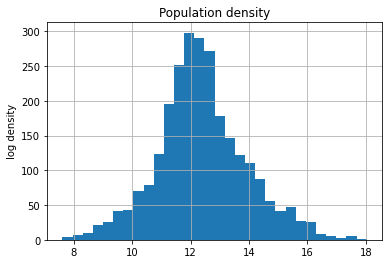

In [8]:
#### Analysis:

## Does population density explain growth rate?
ax = np.log(reg_df.density).hist(bins=30)
ax.set_title('Population density')
ax.set_ylabel('log density')



Text(0, 0.5, 'log rate')

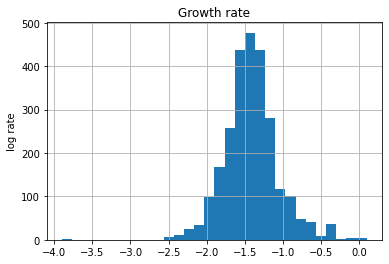

In [9]:
ax = np.log(reg_df.rate).hist(bins=30)
ax.set_title('Growth rate')
ax.set_ylabel('log rate')



Text(0, 0.5, 'log rate')

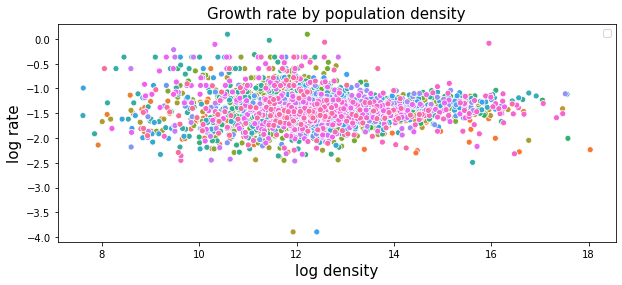

In [10]:
plt.figure(figsize=(10, 4))
ax = sns.scatterplot(x=np.log(reg_df.density), y=np.log(reg_df.rate), hue=reg_df.state)
ax.legend(labels='')
ax.set_title('Growth rate by population density', fontsize=15)
ax.set_xlabel('log density', fontsize=15)
ax.set_ylabel('log rate', fontsize=15)



Text(0.5, 1.0, 'Growth rate')

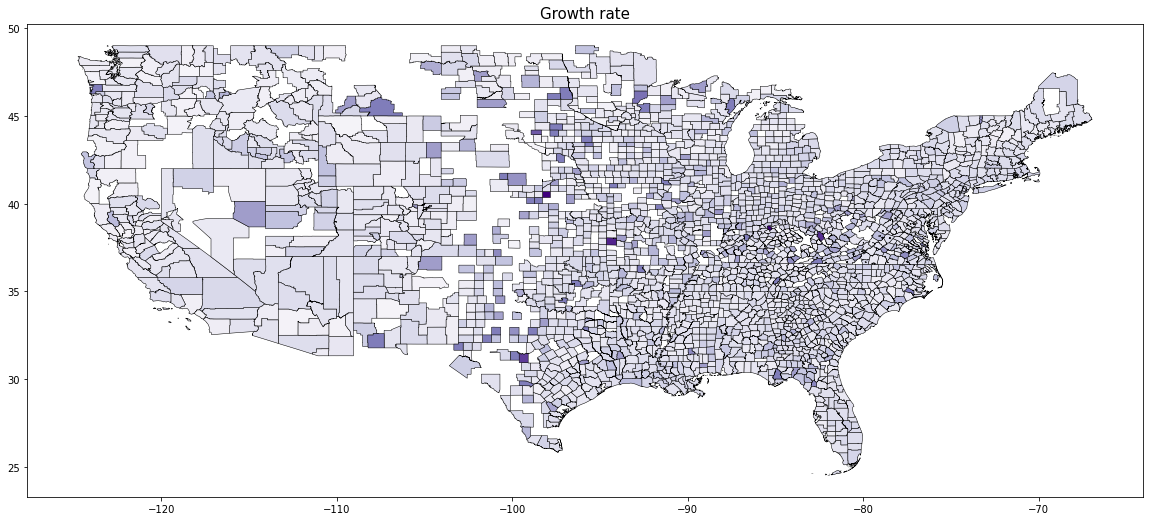

In [11]:

## Does proximity of counties explain growth rate?
ax = reg_df.plot(figsize=(20,10), linewidth=0.5, edgecolor='black', column='rate', cmap='Purples')
ax.set_title('Growth rate', fontsize=15)



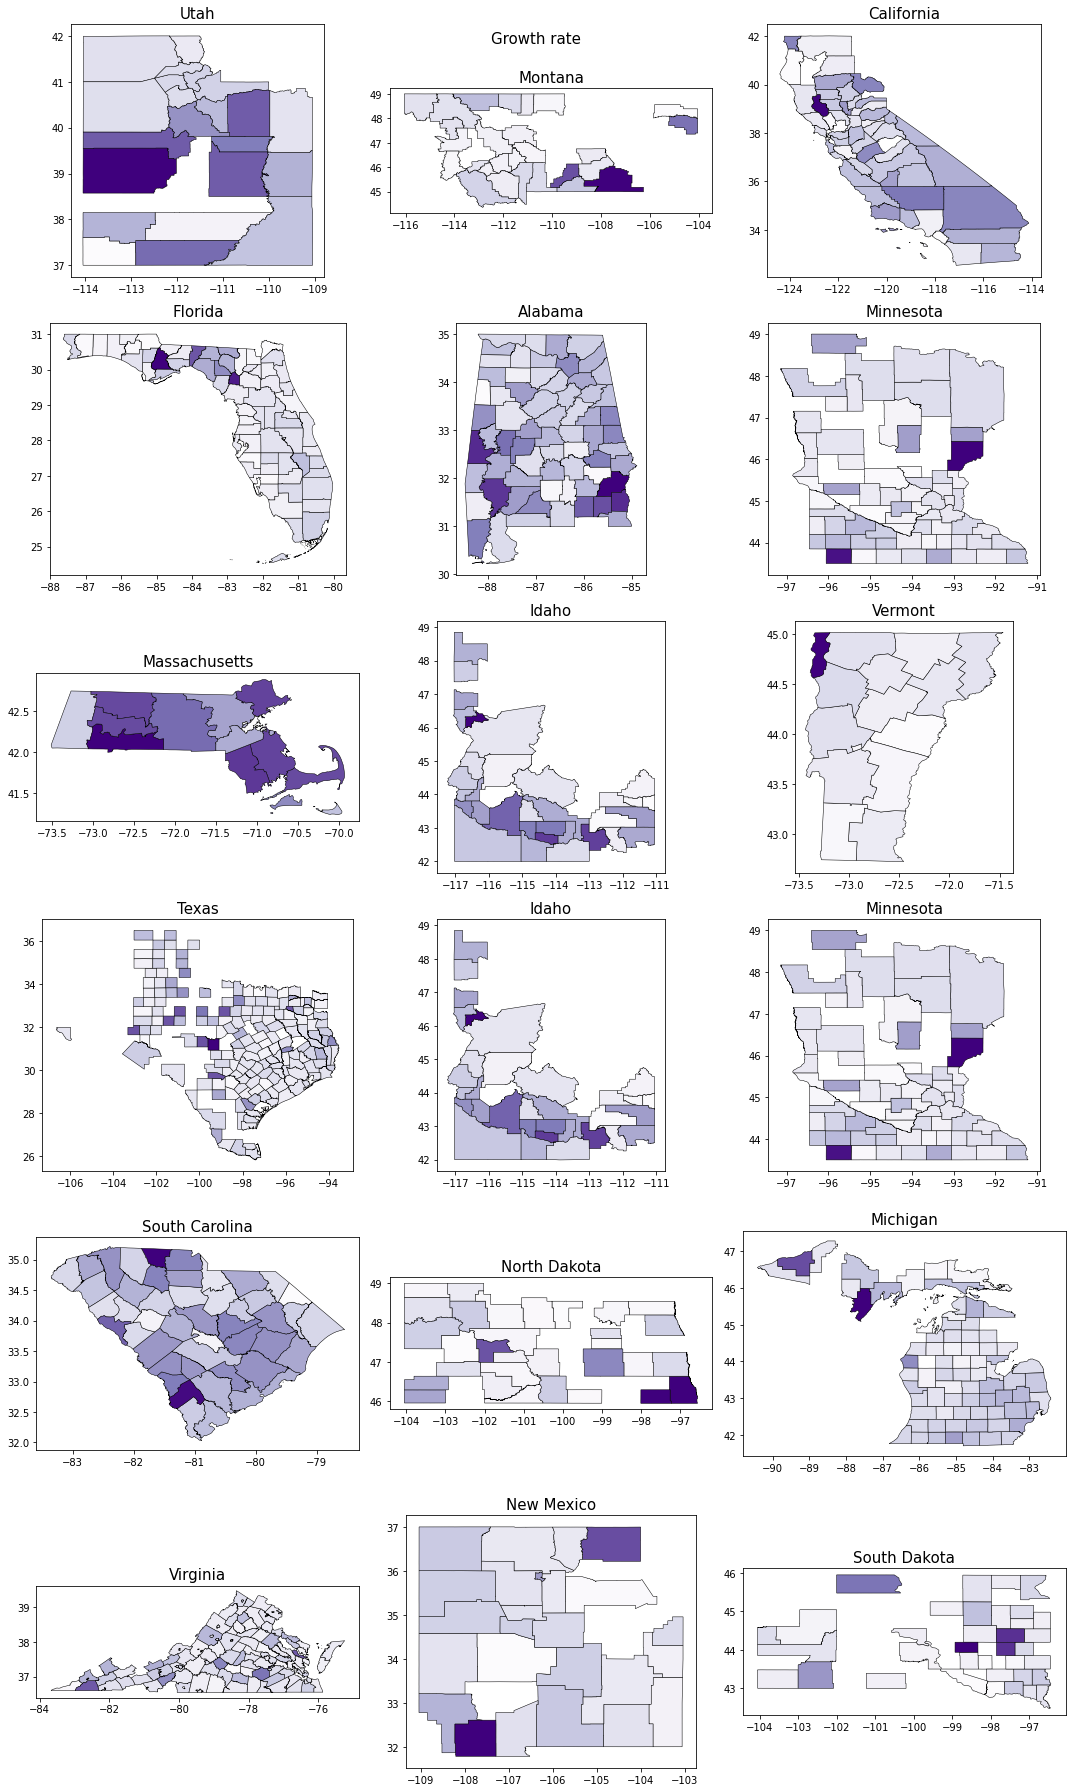

In [12]:
fig, axes = plt.subplots(6, 3, figsize=(15, 25))
fig.suptitle('Growth rate', fontsize=15)
np.random.seed(3)
states_subset = np.random.choice(reg_df.state.unique(), len(axes.reshape(-1)))
for state, ax in zip(states_subset, axes.reshape(-1)):
    reg_df[reg_df.state == state].plot(ax=ax, linewidth=0.5, edgecolor='black', column='rate', cmap='Purples')
    ax.set_title(state, fontsize=15)
fig.tight_layout()

